# German Traffic Signs Detection  
## Cargo 2017

## GTSDB dataset analysis
GTSDB is German traffic signs dataset and can be downloaded from [GTSDB](http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset)

Train has image files with traffic signs numbers: 741
Train has traffic signs class numbers: 43
Train has traffic signs instance numbers: 1213
38    88
12    85
13    83
2     81
10    80
1     79
4     68
8     57
5     53
9     41
7     41
11    38
18    38
14    32
25    31
3     30
17    29
23    20
35    20
6     19
26    18
30    16
33    16
15    15
28    14
22    13
34    12
42    11
40    10
20     9
36     9
32     8
16     8
41     7
39     6
21     5
24     5
29     5
0      4
27     3
19     2
31     2
37     2
Name: id, dtype: int64


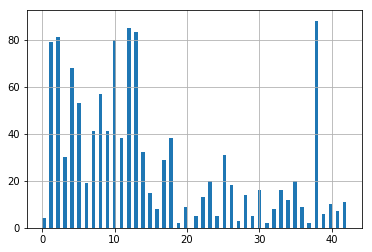

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

import os
os.getcwd()

# TrainIJCNN2013    '../data/TrainIJCNN2013/gt.txt'
#data = pd.read_csv('../data/TrainIJCNN2013/gt.txt', sep=";", header=None)

# FullIJCNN2013     '../data/FullIJCNN2013/gt.txt'
data = pd.read_csv('../data/FullIJCNN2013/gt.txt', sep=";", header=None)
data.columns = ["img", "x1", "y1", "x2", "y2", "id"]
#data=data[:3]

print("Train has image files with traffic signs numbers:", len(data['img'].unique()))
print("Train has traffic signs class numbers:", len(data['id'].unique()))
print("Train has traffic signs instance numbers:", data['id'].count())
#pd.value_counts(data['id'], sort=False).plot.bar()
print(pd.value_counts(data['id'], sort=True))
data['id'].hist(bins=86)

## StratifiedShuffleSplit 

           img   x1   y1   x2   y2  id
143  00271.ppm  259  369  297  408   2
277  00633.ppm  290  501  360  582  38
295  00183.ppm  766  369  806  406  19
           img   x1   y1   x2   y2  id
155  00482.ppm  283  564  303  590  17
332  00486.ppm  410  519  465  574   7
122  00443.ppm  823  579  843  598   8


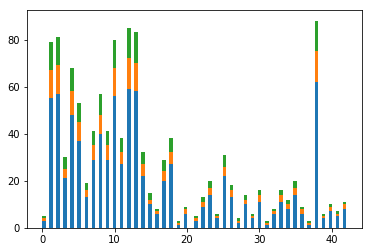

FileNotFoundError: [Errno 2] No such file or directory: '../data/png_FullIJCNN2013/train.csv'

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

data = pd.read_csv('../data/FullIJCNN2013/gt.txt', sep=";", header=None)
data.columns = ["img", "x1", "y1", "x2", "y2", "id"]

def stratifiedshufflesplit(data, test_size=0.3, thres=1):
    y_less = data.groupby("id").filter(lambda x: len(x) <= thres)
    data = pd.concat([data, y_less], ignore_index=True)
    
    sss = StratifiedShuffleSplit(1, test_size=test_size)
    indices = sss.split(data.id.values.reshape(-1,1), data.id.values)
    train_index, test_index = [],[]
    for tr, te in indices:
        train_index.append(tr)
        test_index.append(te)
    xtrain, xtest = data.iloc[train_index[0]], data.iloc[test_index[0]]
    #print(xtest['id'].value_counts())
    return xtrain, xtest

xtrain, xt = stratifiedshufflesplit(data, 0.3, 1)
xtest, xval = stratifiedshufflesplit(xt, 0.5, 1)
print(xtest.head(3))
print(xval.head(3))
 
plt.hist([
        xtrain['id'], 
        #xt['id'],
        xtest['id'], 
        xval['id']
        ], 
        stacked=True, 
        label=["train", "test", "val"],
        bins=86
    )

plt.show()

xtrain['width'] = 1360
xtrain['height'] = 800
xtest['width'] = 1360
xtest['height'] = 800
xval['width'] = 1360
xval['height'] = 800
  
xtrain.to_csv('../data/png_FullIJCNN2013/train.csv', index=False)
xtest.to_csv('../data/png_FullIJCNN2013/test.csv', index=False)
xval.to_csv('../data/png_FullIJCNN2013/val.csv', index=False)

## Create Record and copy test images

In [2]:
import os
import hashlib
import io
import random
import shutil
import configparser
import pylab as plt
import tensorflow as tf
from tqdm import tqdm
from lxml import etree
from PIL import Image, ImageDraw, ImageFont
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util
from collections import namedtuple, OrderedDict
import pandas as pd
from shutil import copyfile


def create_tf_record(examples_list, output_filename):
    
    writer = tf.python_io.TFRecordWriter(output_filename)
    for tf_example in examples_list:
        writer.write(tf_example.SerializeToString())
    writer.close()
    print("Successful created record files")

def save_img_with_box(image, group, img_name, gt_label):

    for index, row in group.object.iterrows():
        x1 = row['x1']
        x2 = row['x2'] 
        y1 = row['y1'] 
        y2 = row['y2'] 
        label = gt_label[int(row['id'])+1]
        
        box = (x1, y1), (x2, y2)
        #print(box, label, img_name)
        font = ImageFont.truetype(cf.get('font_path', 'simsun'), 20)
        drawObject = ImageDraw.Draw(image)  
        drawObject.rectangle(box, outline = "red")  
        drawObject.text([x1+20, y1+20], label,"red", font=font)

    save_dir = target_dir
    if not os.path.exists(save_dir):
        os.makedirs(save_dir) 
    image.save(os.path.join(save_dir, img_name))
    #plt.imshow(image) 
    #plt.show()

def get_label_dict(label_path):
    label_map_dict = {}
    with open(label_path, 'r', encoding="utf-8") as f:
        lines = f.readlines()
        for line in lines:
            if not line.split():
                continue
            line = line.strip()
            number, name = line.split(' ', 1)
            #print(number, name)
            label_map_dict[int(number)] = name
    return label_map_dict

def dict_to_tf_example(img_path,
                       group,
                       gt_label,
                       ignore_difficult_instances=False):
    """Convert gt derived dict to tf.Example proto.
    Notice that this function normalizes the bounding box coordinates provided
    by the raw data.
    """
    # 读取图片数据
    with tf.gfile.GFile(img_path, 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)

    width, height = image.size
    #print(image.size)
    #print(width, height)

    filename = (group.img[:-3] + 'png')
    image_format = b'png'
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []

    for index, row in group.object.iterrows():
        #print(row['id'], gt_label[int(row['id'])+1])
        xmin.append(row['x1'] / width)
        xmax.append(row['x2'] / width)
        ymin.append(row['y1'] / height)
        ymax.append(row['y2'] / height)
        classes_text.append(gt_label[int(row['id'])+1].encode('utf8'))
        classes.append(int(row['id'])+1)
    
    if save_img:    
        save_img_with_box(image, group, filename, gt_label)

    # 把一张图片里的所有object都装到example
    example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename.encode('utf8')),
      'image/source_id': dataset_util.bytes_feature(filename.encode('utf8')),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmin),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmax),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymin),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymax),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return example

def split(df, group):
    data = namedtuple('data', ['img', 'object'])
    gb = df.groupby(group)
    return [data(img, gb.get_group(x)) for img, x in zip(gb.groups.keys(), gb.groups)]

def csv_record(csv, gt_label, out='out.record'):

    examples = pd.read_csv(csv)
    grouped = split(examples, 'img')
    out_examples = []
    #print(grouped[:5])
    for group in grouped:
        img_path = os.path.join(train_img_dir, group.img)
        img_path = img_path[:-3] + "png"
        #print(group.img)
        tf_example = dict_to_tf_example(img_path, group, gt_label)
        out_examples.append(tf_example)
        
    output_dir = os.path.join(data_dir, 'records')
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    output = os.path.join(output_dir, out)
    create_tf_record(out_examples, output)
    print(out + ' has been successful created')
    
def main():
    '''
    train imgs eg:    ./data/TrainIJCNN2013/00039.ppm
    train gt:         ./data/TrainIJCNN2013/train.csv
    test imgs eg:     ./data/TestIJCNN2013/00043.ppm
    train.csv: 
        img,x1,y1,x2,y2,id,width,height
        00246.ppm,1091,354,1134,396,10,1360,800
    '''    
    
    # get label information 
    # label id = gt id + 1
    gt_label = get_label_dict(label_path)
    #print(gt_label[3])
    
    csv_record(train_gt_path, gt_label, 'train.record')
    csv_record(val_gt_path, gt_label, 'val.record')
  
    # copy images from test.csv to test_samples
    examples = pd.read_csv(test_gt_path)
    grouped = split(examples, 'img')
    #print(grouped[:5])
    #for group in grouped:
    #    img_path = os.path.join(train_img_dir, group.img)
    #    img_path = img_path[:-3] + "png"
    #    img_out = os.path.join(test_img_dir, group.img)
    #    img_out = img_out[:-3] + "png"
    #    copyfile(img_path, img_out)
    

save_img = True
data_dir = '../data'
train_img_dir = os.path.join(data_dir, 'png_FullIJCNN2013')
test_img_dir = os.path.join(data_dir, 'test_samples')
target_dir = os.path.join(data_dir, 'input_img_vis_test')
train_gt_path = os.path.join(train_img_dir, 'train.csv')
val_gt_path = os.path.join(train_img_dir, 'val.csv')
test_gt_path = os.path.join(train_img_dir,'test.csv')
label_path = os.path.join(data_dir, 'gtsdb.label')
cf = configparser.ConfigParser()
cf.read('../config/traffic.config')


if __name__ == '__main__': 
    
    main() 

Successful created record files
train.record has been successful created
Successful created record files
val.record has been successful created


## Create pbtxt

In [326]:
import numpy as np

input_file = '../data/gtsdb.label'
output_file = '../data/gtsdb.pbtxt'


with open(output_file, 'w+') as output:
    with open(input_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if not line.split():
                continue
            line = line.strip()
            number, name = line.split(' ', 1)
            output_str = "item { \n" + \
                        "  id: " + number + "\n" + \
                        "  name: \'" + name + '\'' + \
                        "\n}\n\n"

            output.write(output_str)
            
print("Create success.")

Create success.


## Transfer ppm into png
ppm has to be transfered into png format for tensorflow object detection API decoder reason. 

In [301]:
#coding=utf-8 
from PIL import Image 
import os

data_dir = '../data'
#train_img_dir = os.path.join(data_dir, 'TrainIJCNN2013')
train_img_dir = os.path.join(data_dir, 'FullIJCNN2013')
png_img_dir = os.path.join(data_dir, 'png_FullIJCNN2013')


if os.path.exists(png_img_dir):
    shutil.rmtree(png_img_dir)
os.makedirs(png_img_dir) 

for img_name in os.listdir(train_img_dir):
#for img_name in ["00000.ppm","00001.ppm","00002.ppm"]:
    if img_name[-3:] == "ppm":
        img_path = os.path.join(train_img_dir, img_name)
        img = Image.open(img_path)
        png_path = os.path.join(png_img_dir, img_name[:-3]+'png')
        print(png_path)
        img.save(png_path)
        #img.show()

../data/png_FullIJCNN2013/00358.png
../data/png_FullIJCNN2013/00000.png
../data/png_FullIJCNN2013/00001.png
../data/png_FullIJCNN2013/00002.png
../data/png_FullIJCNN2013/00003.png
../data/png_FullIJCNN2013/00004.png
../data/png_FullIJCNN2013/00005.png
../data/png_FullIJCNN2013/00006.png
../data/png_FullIJCNN2013/00007.png
../data/png_FullIJCNN2013/00008.png
../data/png_FullIJCNN2013/00009.png
../data/png_FullIJCNN2013/00010.png
../data/png_FullIJCNN2013/00011.png
../data/png_FullIJCNN2013/00012.png
../data/png_FullIJCNN2013/00013.png
../data/png_FullIJCNN2013/00014.png
../data/png_FullIJCNN2013/00015.png
../data/png_FullIJCNN2013/00016.png
../data/png_FullIJCNN2013/00017.png
../data/png_FullIJCNN2013/00019.png
../data/png_FullIJCNN2013/00020.png
../data/png_FullIJCNN2013/00021.png
../data/png_FullIJCNN2013/00022.png
../data/png_FullIJCNN2013/00023.png
../data/png_FullIJCNN2013/00024.png
../data/png_FullIJCNN2013/00025.png
../data/png_FullIJCNN2013/00026.png
../data/png_FullIJCNN2013/00

../data/png_FullIJCNN2013/00221.png
../data/png_FullIJCNN2013/00222.png
../data/png_FullIJCNN2013/00223.png
../data/png_FullIJCNN2013/00224.png
../data/png_FullIJCNN2013/00225.png
../data/png_FullIJCNN2013/00226.png
../data/png_FullIJCNN2013/00227.png
../data/png_FullIJCNN2013/00228.png
../data/png_FullIJCNN2013/00229.png
../data/png_FullIJCNN2013/00230.png
../data/png_FullIJCNN2013/00231.png
../data/png_FullIJCNN2013/00232.png
../data/png_FullIJCNN2013/00233.png
../data/png_FullIJCNN2013/00234.png
../data/png_FullIJCNN2013/00235.png
../data/png_FullIJCNN2013/00236.png
../data/png_FullIJCNN2013/00237.png
../data/png_FullIJCNN2013/00239.png
../data/png_FullIJCNN2013/00240.png
../data/png_FullIJCNN2013/00241.png
../data/png_FullIJCNN2013/00242.png
../data/png_FullIJCNN2013/00243.png
../data/png_FullIJCNN2013/00244.png
../data/png_FullIJCNN2013/00245.png
../data/png_FullIJCNN2013/00246.png
../data/png_FullIJCNN2013/00247.png
../data/png_FullIJCNN2013/00248.png
../data/png_FullIJCNN2013/00

../data/png_FullIJCNN2013/00461.png
../data/png_FullIJCNN2013/00462.png
../data/png_FullIJCNN2013/00463.png
../data/png_FullIJCNN2013/00464.png
../data/png_FullIJCNN2013/00465.png
../data/png_FullIJCNN2013/00466.png
../data/png_FullIJCNN2013/00467.png
../data/png_FullIJCNN2013/00468.png
../data/png_FullIJCNN2013/00469.png
../data/png_FullIJCNN2013/00470.png
../data/png_FullIJCNN2013/00471.png
../data/png_FullIJCNN2013/00472.png
../data/png_FullIJCNN2013/00473.png
../data/png_FullIJCNN2013/00474.png
../data/png_FullIJCNN2013/00475.png
../data/png_FullIJCNN2013/00476.png
../data/png_FullIJCNN2013/00477.png
../data/png_FullIJCNN2013/00479.png
../data/png_FullIJCNN2013/00480.png
../data/png_FullIJCNN2013/00481.png
../data/png_FullIJCNN2013/00482.png
../data/png_FullIJCNN2013/00483.png
../data/png_FullIJCNN2013/00484.png
../data/png_FullIJCNN2013/00485.png
../data/png_FullIJCNN2013/00486.png
../data/png_FullIJCNN2013/00487.png
../data/png_FullIJCNN2013/00488.png
../data/png_FullIJCNN2013/00

../data/png_FullIJCNN2013/00701.png
../data/png_FullIJCNN2013/00702.png
../data/png_FullIJCNN2013/00703.png
../data/png_FullIJCNN2013/00704.png
../data/png_FullIJCNN2013/00705.png
../data/png_FullIJCNN2013/00706.png
../data/png_FullIJCNN2013/00707.png
../data/png_FullIJCNN2013/00708.png
../data/png_FullIJCNN2013/00709.png
../data/png_FullIJCNN2013/00710.png
../data/png_FullIJCNN2013/00711.png
../data/png_FullIJCNN2013/00712.png
../data/png_FullIJCNN2013/00713.png
../data/png_FullIJCNN2013/00714.png
../data/png_FullIJCNN2013/00715.png
../data/png_FullIJCNN2013/00716.png
../data/png_FullIJCNN2013/00717.png
../data/png_FullIJCNN2013/00719.png
../data/png_FullIJCNN2013/00720.png
../data/png_FullIJCNN2013/00721.png
../data/png_FullIJCNN2013/00722.png
../data/png_FullIJCNN2013/00723.png
../data/png_FullIJCNN2013/00724.png
../data/png_FullIJCNN2013/00725.png
../data/png_FullIJCNN2013/00726.png
../data/png_FullIJCNN2013/00727.png
../data/png_FullIJCNN2013/00728.png
../data/png_FullIJCNN2013/00

## Detection with trained model

In [19]:
# import
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

if tf.__version__ != '1.4.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.4.0!')

# Enviroment set up
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util


# Path to frozen detection graph. This is the actual model that is used for the object detection.
#PATH_TO_CKPT = './model_pb/rfcn/frozen_inference_graph.pb'
PATH_TO_CKPT = './model_pb/frozen_inference_graph.pb'
data_dir = '../data'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(data_dir, 'gtsdb.pbtxt')
#PATH_TO_LABELS = os.path.join(data_dir, 'object-detection.pbtxt')

NUM_CLASSES = 43

# Load model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    
# Loading label map 
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
              (im_height, im_width, 3)).astype(np.uint8)


# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
#PATH_TO_TEST_IMAGES_DIR = os.path.join(data_dir, 'TestIJCNN2013')
PATH_TO_TEST_IMAGES_DIR = os.path.join(data_dir, 'test_samples')
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '0000{}.png'.format(i)) for i in range(2, 3) ]
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in range(1, 2) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      print(scores,classes)
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

[[ 0.76746356  0.57839543  0.42553115  0.28233221  0.12435466  0.09267663
   0.08675713  0.0719574   0.00599969  0.00472642]] [[ 11.   9.   9.   8.   6.   5.   6.  11.   7.  39.]]


TypeError: expected string

In [20]:
#coding:utf-8
"""
使用说明:
    输入输出:
        1. 读取test_images里面的文件进行推理,输出到output/TSD-Signal-Result-Cargo目录
        2. test_images下的图片位置为TSD-Signal-**/*.png
        3. 输出xml的文件名就是上面图片的目录名TSD-Signal-**
        4. 所有路径指定在页面底部.
    功能:
        1. 得到推理结果xml,用于提交
        2. 得到推理结果图片,用于调试
        3. 得到F1等统计结果,用于调试

"""
import os
import sys
import cv2
import glob
import shutil
import configparser
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from f1_score import Score
from write_xml import build_xml
from PIL import ImageFont, ImageDraw, Image

def get_label_dict(label_path):
    label_map_dict = {}
    label_list = []
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if not line.split():
                continue
            line = line.strip()
            number, name = line.split(' ', 1)
            label_map_dict[name] = int(number)
            label_list.append(name)
            assert len(label_list) == int(number), str(label_list) + ' ' + number

    # assert len(label_map_dict) == 77
    return label_map_dict, label_list

def to_image_coords(boxes, height, width):
    box_coords = np.zeros_like(boxes)
    box_coords[:, 1] = boxes[:, 0] * height
    box_coords[:, 0] = boxes[:, 1] * width
    box_coords[:, 3] = boxes[:, 2] * height
    box_coords[:, 2] = boxes[:, 3] * width
    
    return box_coords

def draw_box_and_text(image, box, label, pred_score, font_size, font):
    pt1 = (int(box[0]), int(box[1]))
    pt2 = (int(box[2]), int(box[3]))
    # bounding object
    cv2.rectangle(image, pt1, pt2, (255, 0, 0), 2)
    # label text and box
    label_text = "{}: {:.1f}%".format(label, pred_score*100)
    label_w, label_h= int(14.5*len(label_text)+4), font_size+4
    label_start = (pt2[0], pt1[1])
    # TODO: 多标签重叠处理
    # 如果x标签超出了最右边：
    #   如果y标签不会超出最上边，移动到上面显示
    #   如果y超出了最上面，移动到下面显示
    if label_start[0] + label_w > image.shape[1]:
        if label_start[1] - label_h > 0:
            shift = (- label_w, - label_h - 1)
        else:
            shift = (- label_w, pt2[1]-pt1[1] + 2)
        label_start = (label_start[0] + shift[0], label_start[1] + shift[1])

    label_end = (label_start[0] + label_w, label_start[1] + label_h)
    cv2.rectangle(image, label_start, label_end, (0, 255, 0), -1)
    
    # 转换为PIL写入中文后再转为cv2
    cv2_im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2和PIL中颜色的hex码的储存顺序不同
    pil_im = Image.fromarray(cv2_im)
    drawObject = ImageDraw.Draw(pil_im) 
    drawObject.text((label_start[0] + 2, label_start[1] + 2), label_text,"red", font=font)
    image = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)    

    return image
# 非极大值抑制 from: http://blog.csdn.net/gan_player/article/details/78204960
def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    if len(dets) == 0:
        return []
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    #从大到小排列，取index
    order = scores.argsort()[::-1]  #逆序排序
    #keep为最后保留的边框
    keep = []
    while order.size > 0:
        #order[0]是当前分数最大的窗口，之前没有被过滤掉，肯定是要保留的
        i = order[0]
        keep.append(i)

        #计算窗口i与其他所以窗口的交叠部分的面积，矩阵计算
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        #交/并得到iou值
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        #ind为所有与窗口i的iou值小于threshold值的窗口的index，其他窗口此次都被窗口i吸收
        inds = np.where(ovr <= thresh)[0]
        #下一次计算前要把窗口i去除，所有i对应的在order里的位置是0，所以剩下的加1
        order = order[inds + 1]
    return keep


def load_graph():
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return detection_graph

def main():
    #score = Score(GT_xmls_dir)   
    cf = configparser.ConfigParser()
    cf.read('../config/traffic.config')    
    font_size = 20
    font = ImageFont.truetype(cf.get('font_path', 'simsun'), font_size) 
    #font = ImageFont.truetype('FreeSerif.ttf', font_size)

    _, label_list = get_label_dict(label_path)
    detection_graph = load_graph()
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            ii = 0
  
            for image_name in os.listdir(img_dir):
            #for image_name in ['00000.png','00001.png','00002.png','00003.png','00004.png','00005.png','00006.png','00007.png','00008.png','00009.png']:
                image_path = os.path.join(img_dir, image_name)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # TODO
                (im_height, im_width, _) = image.shape
                image_np_expanded = np.expand_dims(image, axis=0)
                (boxes, scores, classes, num) = sess.run(
                        [detection_boxes, detection_scores, detection_classes, num_detections],
                        feed_dict={image_tensor: image_np_expanded})
                box_coords = to_image_coords(boxes[0], im_height, im_width)
                    
                # 获得符合最低置信度的预测结果
                pred_idx = []
                for i, pred in enumerate(scores[0]):
                    if pred > pred_threshold:
                        pred_idx.append([i, pred])

                targets = []
                dets = []
                for idx, pred in pred_idx:
                    clazz = int(classes[0][idx:idx+1][0])
                    label = label_list[clazz-1]   
                    box = box_coords[idx:idx+1][0]
                    targets.append([label, box, pred])
                    dets.append([box[0], box[1], box[2], box[3], pred])
                dets = np.array(dets)
                    
                # 非极大值抑制
                y = py_cpu_nms(dets, 0.3)
                a = len(targets) - len(y)
                if a > 0: print('NMS Droped: ', a)
                targets = [targets[i] for i in y]
                # 写入结果框到image
                for label, box, pred in targets:
                    image = draw_box_and_text(image, box, label, pred, font_size, font)
                    
                # 计算score
                # is_pass = score.update(image_name, img_dir, targets)
                    
                # 生成结果图片 正确的和错误的分开保存
                #if is_gen_img:
                #    if not is_pass: # TODO : 真值 box和type写入
                #        cv2.imwrite(os.path.join(fail_case_dir, image_name), image)                        
                #    else:
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                cv2.imwrite(os.path.join(img_result_dir, image_name), image)

    return score

data_dir = '../data'
output_dir = '../output'
test_dir = os.path.join(data_dir, 'test_samples')
img_dir = test_dir
label_path = os.path.join(data_dir,'gtsdb.label')
img_result_dir = os.path.join(output_dir, 'test_result')

pb_path = './model_pb/rfcn/frozen_inference_graph.pb'
#pb_path = './model_pb/rcnn_resnet50/frozen_inference_graph.pb'

pred_threshold = 0.3

# 是否生成带框的结果图片
is_gen_img = True


if __name__ == '__main__':

    if os.path.exists(img_result_dir):
        shutil.rmtree(img_result_dir)
    os.makedirs(img_result_dir)    
    
   
    score = main()
    '''
    f1, precision, recall = score.get_f1_score() 

    acc, total = score.get_combine_accuracy()
    box_acc = score.get_box_accuracy()

    print(score.TP, score.FP, score.box_TP, score.box_FP)

    #print("F1 score: %.2f, precision: %.2f, recall: %.2f" %(f1, precision, recall))
    print('Total: ', total, ", Accuracy: ", format(acc,'0.1%'))
    print("box_acc: ", format(box_acc,'0.1%'))
    print("box match but type not match count: ", score.type_missed_count)

    '''


NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  2
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  2
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1
NMS Droped:  1


NameError: name 'score' is not defined